In [1]:
"""
TPOTでスタートアップの資金調達を分類
グループ分類：資金調達0円or1円以上
適用分野：全分野
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from tpot import TPOTClassifier
from contextlib import redirect_stdout

# 再現性のための乱数シードの固定
seed = 42
np.random.seed(seed)

# データの読み込み
df = pd.read_excel("C:/Users/user/python/UnivStartups_Takagi/Data/Master_Researcher-Data_20231026.xlsx")

# 資金調達額によるグループ分け
df['group'] = pd.cut(df['資金調達額(百万円)'], bins=[-float('inf'), 0, float('inf')], labels=[0, 1])

# 分析に使用するカラムの指定
columns_to_check = ["institution score",
                    "研究課題数", 
                    "配分額", 
                    "最大配分額", 
                    "平均配分額", 
                    "h-index", 
                    "Avg Documents Per Year",
                    "Document Count (All years)",
                    "Cited By Count (All years)", 
                    "Max Cited By (All years)",
                    "Avg Cited By (All years)", 
                    "Max JIF (All years)", 
                    "Avg JIF (All years)", 
                    "Max JCI (All years)",
                    "Avg JCI (All years)", 
                    "Document Count(5 years)", 
                    "Cited By Count (5 years)", 
                    "Max Cited By (5 years)",
                    "Avg Cited By (5 years)", 
                    "Max JIF (5 years)", 
                    "Avg JIF (5 years)", 
                    "Max JCI (5 years)", 
                    "Avg JCI (5 years)",
                    "研究委託回数合計", 
                    "研究受託回数合計", 
                    "研究協力回数合計", 
                    "研究受託費用一意合計", 
                    "研究協力費用一意合計", 
                    "研究委託研究者数",
                    "研究受託研究者数", 
                    "研究共同研究者数", 
                    "研究協力者総数", 
                    "研究費合計", 
                    "共著者のべ人数", 
                    "共著者数"]

# NaN値の処理
df[columns_to_check] = df[columns_to_check].fillna(df[columns_to_check].median())

# 企業別の最大値集計とスケーリング
aggregated_df = df.groupby('企業名')[columns_to_check].max()
aggregated_df['group'] = df.drop_duplicates('企業名').set_index('企業名')['group']
aggregated_df[columns_to_check] = StandardScaler().fit_transform(aggregated_df[columns_to_check])

# グループごとにデータを分割
group0 = aggregated_df[aggregated_df['group'] == 0]
group1 = aggregated_df[aggregated_df['group'] == 1]

# 各グループのサンプル数
num_samples_group0 = len(group0)
num_samples_group1 = len(group1)

# 各グループから等しい数のサンプルを選択
n = min(num_samples_group0, num_samples_group1)
group0_downsampled = resample(group0, replace=False, n_samples=n, random_state=seed)
group1_downsampled = resample(group1, replace=False, n_samples=n, random_state=seed)

# ダウンサンプリングしたデータを結合
df_balanced = pd.concat([group0_downsampled, group1_downsampled])

# 結果の表示
print("Group 0 Sample Count:", num_samples_group0)
print("Group 1 Sample Count:", num_samples_group1)
print("Number of Samples Used for Downsampling:", n)
print("Remaining Samples in Group 0 After Downsampling:", num_samples_group0 - n)
print("Remaining Samples in Group 1 After Downsampling:", num_samples_group1 - n)

# 訓練データの準備
X = df_balanced[columns_to_check].values
y = df_balanced['group'].astype(int).values

Group 0 Sample Count: 95
Group 1 Sample Count: 99
Number of Samples Used for Downsampling: 95
Remaining Samples in Group 0 After Downsampling: 0
Remaining Samples in Group 1 After Downsampling: 4


In [5]:
# ログからスコアを解析してプロットする関数
def plot_scores_from_log(log_content):
    generation_scores = []
    for line in log_content.split('\n'):
        if 'Generation' in line:
            score_match = re.search('Current best internal CV score: ([\d\.]+)', line)
            if score_match:
                score = float(score_match.group(1))
                generation_scores.append(score)

    if generation_scores:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(generation_scores) + 1), generation_scores, marker='o')
        plt.xlabel('Generation')
        plt.ylabel('Score')
        plt.title('Score per Generation')
        plt.show()
    else:
        print("No generation scores were captured.")

# 混合行列をプロットする関数
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    props = dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='blue', alpha=1)
    textstr = '\n'.join(('0: Funding Amount = 0', '1: Funding Amount > 0'))
    plt.gca().text(0.01, 1.00, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)
    plt.title(f'{title} ({fold})' if fold else title)
    plt.show()
        
# 混合行列と評価指標を表示する関数
def display_model_evaluation(X, y, classifier):
    # 全データセットに対する予測
    y_pred = classifier.predict(X)

    # 混合行列の計算
    cm = confusion_matrix(y, y_pred)

    # スコアの計算
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)

    # 混合行列の表示
    plot_confusion_matrix(cm, 'Confusion Matrix')

    # スコアの表示
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")

# TPOTClassifierの設定と訓練の関数
def train_tpot_and_capture_log(X, y, generations, population_size, checkpoint_dir, seed=seed, tpot_instance=None):
    tpot = TPOTClassifier(generations=generations, # 遺伝的アルゴリズムが進化する世代の数
                          population_size=population_size, # 各世代でのパイプラインの数
                          offspring_size=None, # 各世代で生成される子供（新しいパイプライン）の数,Noneだとpopulation_sizeと同数
                          mutation_rate=0.7, # 新しい子供が突然変異を受ける確率
                          crossover_rate=0.3, # 新しい子供が交叉（二つのパイプラインの組み合わせ）を通じて生成される確率
                          scoring='accuracy', # モデルの性能を評価するためのスコアリング関数 
                          cv=5,
                          subsample=1.0, # トレーニングデータのサブサンプルの割合
                          n_jobs=-1, # 同時に実行するジョブの数
                          max_time_mins=None, # TPOTが最適化を実行する最大時間
                          max_eval_time_mins=10, # 各パイプラインの評価に許される最大時間
                          random_state=seed, # 乱数生成器のシード
                          config_dict=None, # 使用する機械学習演算子とパラメータの辞書
                          template=None, # パイプラインの構造を指定する文字列テンプレート
                          warm_start=False, # Trueに設定されている場合,TPOTは前回の実行からパイプラインを継続して構築
                          memory=None, # パイプラインのキャッシュを格納するディレクトリ
                          use_dask=False, # Trueに設定すると分散コンピューティングフレームワークのDaskを使用して計算
                          periodic_checkpoint_folder=checkpoint_dir, # 進行状況を保存するディレクトリ
                          early_stop=None, # モデルが一定の世代にわたって改善されない場合に早期停止する世代数
                          verbosity=2, # ログ出力のレベル
                          disable_update_check=False, # Trueに設定するとTPOTの更新をチェックしない
                          log_file=None # ログメッセージを書き込むファイルの名前
                          )

    log_stream = io.StringIO()
    with redirect_stdout(log_stream):
        tpot.fit(X, y)
    log_content = log_stream.getvalue()
    return tpot, log_content

# 実行時間を計測する関数
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time} seconds")
    return result

Optimization Progress:   0%|          | 0/105 [00:00<?, ?pipeline/s]

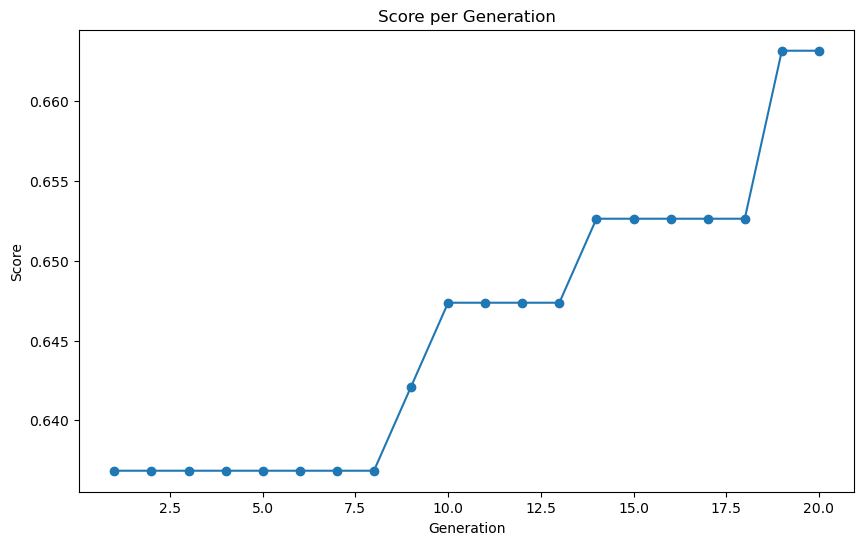

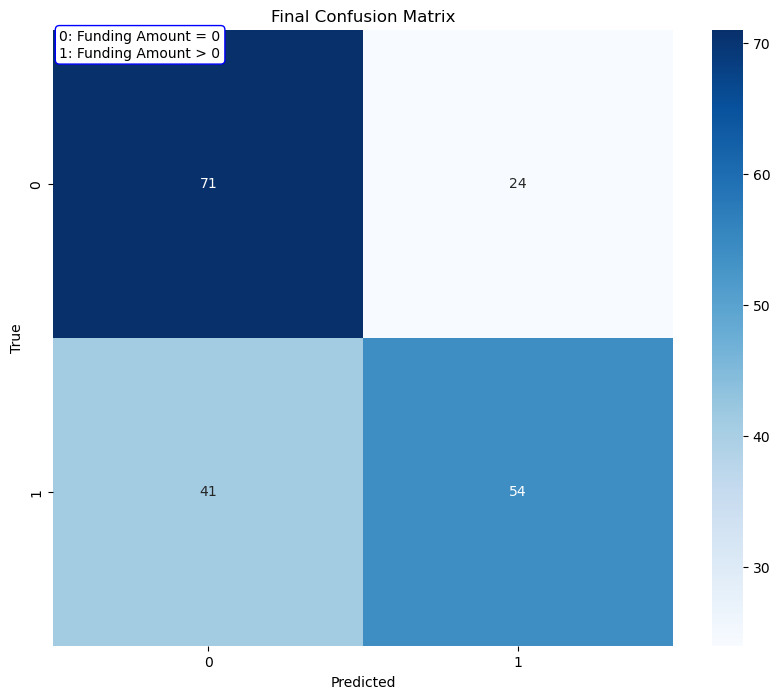

Accuracy: 0.66
Precision: 0.69
F1 Score: 0.62
The best pipeline found by TPOT:
Pipeline(steps=[('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=True,
                                      max_features=0.6500000000000001,
                                      min_samples_leaf=20, min_samples_split=10,
                                      random_state=42))])


In [6]:
# 初回のトレーニング実行

checkpoint_dir = 'TPOT_funding_0or1_all'  # チェックポイントディレクトリ
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

num_generations = 20  # トレーニングのための世代数
num_population_size = 5  # パイプラインの数

# TPOT分類器の訓練とログのキャプチャ
tpot_classifier, training_log = measure_time(train_tpot_and_capture_log, X, y, num_generations, num_population_size, checkpoint_dir, seed=seed)
# キャプチャしたログからスコアをプロット
plot_scores_from_log(training_log)

# 混合行列と評価指標の表示
display_model_evaluation(X, y, tpot_classifier)

# 使用したモデルの表示
print("The best pipeline found by TPOT:")
print(tpot_classifier.fitted_pipeline_)

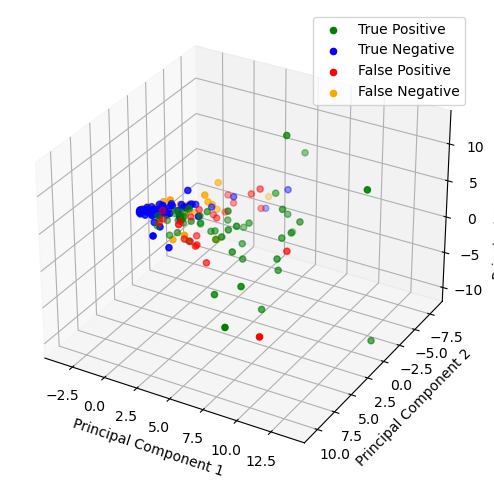

In [20]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# モデルの予測結果を取得
y_pred = tpot_classifier.predict(X)

# 陽性（True Positive）、陰性（True Negative）、偽陽性（False Positive）、偽陰性（False Negative）を識別
true_positive = (y_pred == 1) & (y == 1)
true_negative = (y_pred == 0) & (y == 0)
false_positive = (y_pred == 1) & (y == 0)
false_negative = (y_pred == 0) & (y == 1)

# PCAのインスタンスを作成して適用（3次元）
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# 3Dプロットの作成
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# それぞれのカテゴリに対してプロット
ax.scatter(X_pca[true_positive, 0], X_pca[true_positive, 1], X_pca[true_positive, 2], color='green', label='True Positive')
ax.scatter(X_pca[true_negative, 0], X_pca[true_negative, 1], X_pca[true_negative, 2], color='blue', label='True Negative')
ax.scatter(X_pca[false_positive, 0], X_pca[false_positive, 1], X_pca[false_positive, 2], color='red', label='False Positive')
ax.scatter(X_pca[false_negative, 0], X_pca[false_negative, 1], X_pca[false_negative, 2], color='orange', label='False Negative')

# y軸の範囲を逆順に設定
ax.set_ylim(ax.get_ylim()[::-1])

# ラベルと凡例の追加
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()

plt.show()